In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Sobol's Sequence

Like latin hypercube sampling, Sobol's sequence is a low discrepancy sequence that is used to generate points in a multidimensional space. It is a deterministic sequence that is designed to fill the space more uniformly than random sampling. We will just take a brief look at the mathematics behind the sequence, following the notation of [Joe and Kuo 2008](https://epubs.siam.org/doi/10.1137/070709359).

First, we will initialize primitive polynomials

For each dimension $j$, we need to choose a primitive polynomial of degree $s_j$ that is defined on the field of integers modulo 2.

The polynomial will take the form:

$$
x^{s_j} + a_{1, j} x^{s_j-1} + a_{2, j} x^{s_j-2} + \ldots + a_{s_j - 1, j}x+1
$$

Where the coefficients $a_{j, k}$ are either 0 or 1

Next, we will define a sequence of positive integers using a recursive formula. 

$$
m_{k, j} = 2a_{1, j}m_{k-1, j} \oplus 2^2a_{2, j}m_{k-2, j} \oplus \ldots \oplus 2^{s_j-1}a_{s_j-1, j}m_{k-s_j+1, j}
$$

where $\oplus$ is the bitwise XOR operation. The initial values are $m_{k, j}$ for $1 \leq k \leq s_j$ are odd and less than $2^{k}$

Then we will define what are called the *direction numbers*, $v_{j, k}$, which determine the direction the sequence travels through each dimension, trying to cover the space uniformly. We will define them as:

$$
v_{k, j} = \frac{m_{k, j}}{2^k}
$$

Finally, we will define the Sobol's sequence as:

$$
x_{i, j} = i_1 v_{1, j} \oplus i_2 v_{2, j} \oplus \ldots
$$

where $i_1, i_2, \ldots$ are the binary digits of $k$



This notebook will show how to generate Sobol's sequence using scipy's implementation. Let's take a look at the usage in two dimensions.

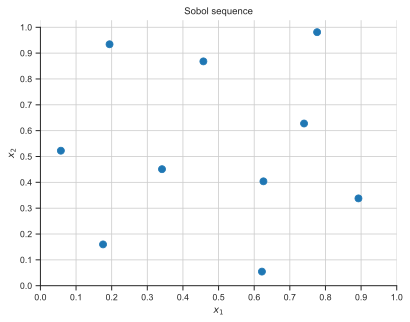

In [54]:
import scipy.stats.qmc as qmc
import jax.numpy as jnp
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Define parameters
dim = 3
num_samples = 10

# Initialize Sobol sampler
sampler = qmc.Sobol(d=dim, scramble=True)

# Generate samples
X = sampler.random(n=num_samples)

# Plotting
fig, ax = plt.subplots()
ax.grid(which='major')
# Scatter plot for the Latin Hypercube samples
ax.scatter(X[:, 0], X[:, 1], 50., color=sns.color_palette()[0])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
# Create the grid positions based on the Latin Hypercube intervals
grid_positions = jnp.linspace(0, 1, num_samples + 1)
# Set the grid to match the Latin Hypercube intervals
ax.set_xticks(grid_positions)
ax.set_yticks(grid_positions)
ax.set_title('Sobol sequence')
sns.despine(trim=True)

Note that while the samples from Sobol's sequence are well space, they do not follow the partitioning of the space that latin hypercube sampling does.
Let's compare directly with latin hypercube sampling in two dimensions.

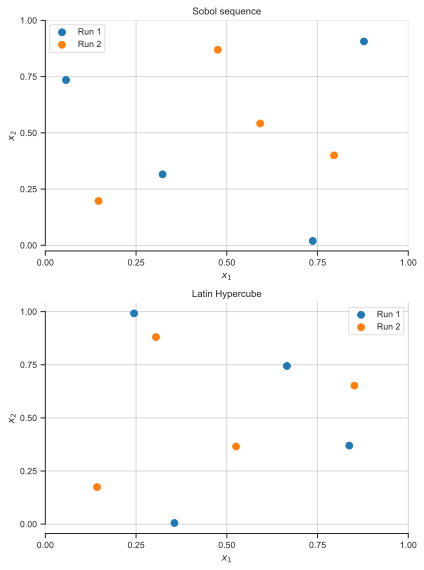

In [55]:
dim = 2
# Note that the number of samples must be a power of 2 for LHS
num_samples = 4

# Intialize Sobol sampler
sobol_sampler = qmc.Sobol(d=dim, scramble=True)

# Initialize LHS sampler
lhs_sampler = qmc.LatinHypercube(d=dim)

# Generate samples for two runs
sobol_X1 = sobol_sampler.random(n=num_samples)
sobol_X2 = sobol_sampler.random(n=num_samples)
lhs_X1 = lhs_sampler.random(n=num_samples)
lhs_X2 = lhs_sampler.random(n=num_samples)


# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# Scatter plot for the Sobol samples
ax1.scatter(sobol_X1[:, 0], sobol_X1[:, 1], 50., color=sns.color_palette()[0], label='Run 1')
ax1.scatter(sobol_X2[:, 0], sobol_X2[:, 1], 50., color=sns.color_palette()[1], label='Run 2')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
# Create the grid positions based on the Latin Hypercube intervals
grid_positions = jnp.linspace(0, 1, num_samples + 1)
# Set the grid to match the Latin Hypercube intervals
ax1.set_xticks(grid_positions)
ax1.set_yticks(grid_positions)
ax1.grid(which='major')
ax1.legend()
ax1.set_title('Sobol sequence')

# Scatter plot for the Latin Hypercube samples
ax2.grid(which='major')
ax2.scatter(lhs_X1[:, 0], lhs_X1[:, 1], 50., color=sns.color_palette()[0], label='Run 1')
ax2.scatter(lhs_X2[:, 0], lhs_X2[:, 1], 50., color=sns.color_palette()[1], label='Run 2')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
# Create the grid positions based on the Latin Hypercube intervals
grid_positions = jnp.linspace(0, 1, num_samples + 1)
# Set the grid to match the Latin Hypercube intervals
ax2.set_xticks(grid_positions)
ax2.set_yticks(grid_positions)
ax2.grid(which='major')
ax2.legend()
ax2.set_title('Latin Hypercube')

sns.despine(trim=True)
plt.grid(True)

plt.tight_layout()
plt.show()

The primary motivation for using Sobol sequences over Latin hypercube sampling (LHS) comes from the continuation problem. When sampling using LHS, the space is *stratified* or partitioned into equal intervals based on the number of samples, $N$. This can lead to a problem when trying to continue the sampling, as the new samples will be forced to be in the same strata as the previous samples. This can introduce a bias in the sampling. If you want to take more samples using LHS, you will have to re-stratify these space to ensure uniform sampling. Whereas Sobol sequences are inherently extensible, and you can continue to generate more samples without introducing bias.

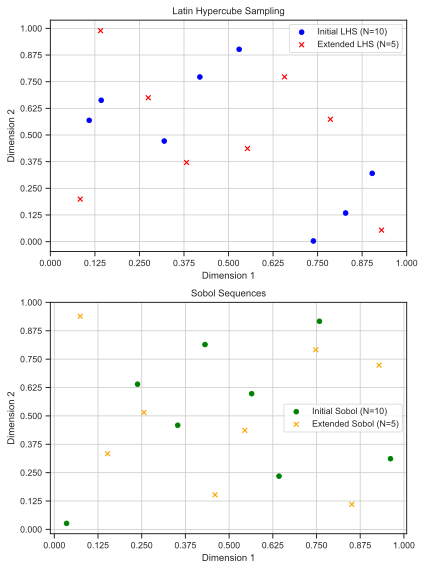

In [56]:
# Parameters
dimension = 2
# Note that the number of samples must be a power of 2
N_initial = 8
N_extended = 8 # Additional samples to extend

# 1. Generate Initial Latin Hypercube Samples
lhs_sampler_initial = qmc.LatinHypercube(d=dimension, seed=42)
lhs_initial = lhs_sampler_initial.random(n=N_initial)

# 2. Generate Initial Sobol Samples
sobol_sampler = qmc.Sobol(d=dimension, scramble=True, seed=42)
sobol_initial = sobol_sampler.random(n=N_initial)

# 3. Extend Latin Hypercube Samples (This does not maintain stratification)
lhs_sampler_extended = qmc.LatinHypercube(d=dimension, seed=24)
lhs_extended = lhs_sampler_extended.random(n=N_extended)

# 4. Extend Sobol Samples (Maintains uniformity)
sobol_extended = sobol_sampler.random(n=N_extended)

# 5. Combine Samples
lhs_combined = jnp.vstack([lhs_initial, lhs_extended])
sobol_combined = jnp.vstack([sobol_initial, sobol_extended])

# 6. Visualization
fig, axes = plt.subplots(2, 1, figsize=(6, 8))

# Plot LHS Samples
axes[0].scatter(lhs_initial[:, 0], lhs_initial[:, 1], c='blue', label='Initial LHS (N=10)')
axes[0].scatter(lhs_extended[:, 0], lhs_extended[:, 1], c='red', label='Extended LHS (N=5)', marker='x')
axes[0].set_title('Latin Hypercube Sampling')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
grid_positions = jnp.linspace(0, 1, N_initial + 1)
axes[0].set_xticks(grid_positions)
axes[0].set_yticks(grid_positions)
axes[0].grid(which='major')
axes[0].legend()

# Plot Sobol Samples
axes[1].scatter(sobol_initial[:, 0], sobol_initial[:, 1], c='green', label='Initial Sobol (N=10)')
axes[1].scatter(sobol_extended[:, 0], sobol_extended[:, 1], c='orange', label='Extended Sobol (N=5)', marker='x')
axes[1].set_title('Sobol Sequences')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].legend()
axes[1].set_xticks(grid_positions)
axes[1].set_yticks(grid_positions)
axes[1].grid(which='major')

plt.tight_layout()
plt.show()

As you can see, some of the extended LHS samples do not follow the grid pattern that we are used to seeing and therefore not accomplishing the goal of filling the space uniformly. This is where Sobol sequences shine, they are naturally extendable as they are a sequence that can be continued indefinitely.

Now that you understand that the Sobol sequence extends naturally, the additional points will not be differentiated. 
Now we want to compare the *discrepancy* of the two sampling methods. Discrepancy is a measure of how well the points fill the space. The *Centered Discrepancy* measure  of a set of points is defined as:

$$
D_C(P) = \sup_{x \in [0, 1]^d} \left| \frac{N(\mathcal{P}, \mathbf{x})}{n} - \operatorname{Vol}([0, \mathbf{x}]) \right|
$$

where $N(\mathcal{P}, \mathbf{x})$ is the number of points in the set $\mathcal{P}$ that are contained in the hypercube $[0, \mathbf{x}]$ 

But again we will just use scipy's implementation to calculate the discrepancy.
Lets go ahead and visualize LHS and the sobol sequence in 3 dimensions this time and see the discrepancy for each method.

In [57]:
def plot_comparison(initial_samples, additional_samples):
    """
    Generate and plot Sobol and LHS samples in 3D, and calculate discrepancy measures.
    
    Parameters:
    - initial_samples (int): Number of initial samples to generate with stratification (LHS).
    - additional_samples (int): Number of additional samples to add, introducing bias to LHS.
    """
    
    # Total samples
    total_samples = initial_samples + additional_samples
    
    # 1. Generate Initial LHS Samples
    lhs_sampler_initial = qmc.LatinHypercube(d=3, seed=42)
    lhs_initial = lhs_sampler_initial.random(n=initial_samples)
    
    # 2. Generate Additional LHS Samples (without maintaining stratification)
    # This simulates the continuation problem
    lhs_sampler_additional = qmc.LatinHypercube(d=3, seed=24)
    lhs_additional = lhs_sampler_additional.random(n=additional_samples)
    
    # Combine LHS samples
    lhs_combined = jnp.vstack([lhs_initial, lhs_additional])
    
    # 3. Generate Sobol Samples
    sobol_sampler = qmc.Sobol(d=3, scramble=True, seed=42)
    sobol_combined = sobol_sampler.random(n=total_samples)
    
    # 4. Calculate Discrepancy Measures
    # Using SciPy's discrepancy function
    # Note: SciPy's discrepancy requires input to be in [0,1]^d
    lhs_discrepancy = qmc.discrepancy(lhs_combined, method='CD')  # Using L2 discrepancy
    sobol_discrepancy = qmc.discrepancy(sobol_combined, method='CD')
    
    # 5. Plotting
    fig = plt.figure(figsize=(16, 7))
    
    # 3D Plot for LHS
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(lhs_initial[:, 0], lhs_initial[:, 1], lhs_initial[:, 2],
                c='blue', label='Initial LHS', marker='o', s=50, alpha=0.6)
    ax1.scatter(lhs_additional[:, 0], lhs_additional[:, 1], lhs_additional[:, 2],
                c='red', label='Additional LHS', marker='x', s=50, alpha=0.8)
    ax1.set_title('Latin Hypercube Sampling (Initial + Additional)', fontsize=14)
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    ax1.set_zlabel('Dimension 3')
    ax1.set_xticks(jnp.linspace(0, 1, initial_samples + 1))
    ax1.set_yticks(jnp.linspace(0, 1, initial_samples + 1))
    ax1.set_zticks(jnp.linspace(0, 1, initial_samples + 1))
    ax1.legend()
    ax1.grid(True)
    
    # 3D Plot for Sobol
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(sobol_combined[:, 0], sobol_combined[:, 1], sobol_combined[:, 2],
                c='blue', label='Sobol Sequence', marker='o', s=50, alpha=0.6)
    ax2.set_title('Sobol Sequence Sampling', fontsize=14)
    ax2.set_xlabel('Dimension 1')
    ax2.set_ylabel('Dimension 2')
    ax2.set_zlabel('Dimension 3')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Display Discrepancy Measures
    print("Discrepancy Measures (L2-Star Discrepancy):")
    print(f"  - Latin Hypercube Sampling: {lhs_discrepancy:.5f}")
    print(f"  - Sobol Sequence Sampling:    {sobol_discrepancy:.5f}")


To use the widget and visualize the 3D plot, you will need to launch and run the notebook yourself.

In [58]:
dim = 3
sobol_sampler = qmc.Sobol(d=dim, scramble=True, seed=42)

# Define sliders for initial and additional samples
initial_slider = widgets.Dropdown(
    options=[2**i for i in range(6)],  # Powers of 2 up to 2^5 (32)
    value=8,
    description='Initial Samples:',
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

additional_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=20,
    step=1,
    description='Additional Samples:',
    continuous_update=False,
    style={'description_width': 'initial'},
    layout={'width': '50%'}
)

# Display the interactive widgets and link them to the plotting function
widgets.interact(plot_comparison, initial_samples=initial_slider, additional_samples=additional_slider);



interactive(children=(Dropdown(description='Initial Samples:', index=3, layout=Layout(width='50%'), options=(1…

Note the disrepancy of the Sobol sequence is lower than LHS when additional samples are taken.

Lets plot the discrepancy for each method as a function of additional samples taken.

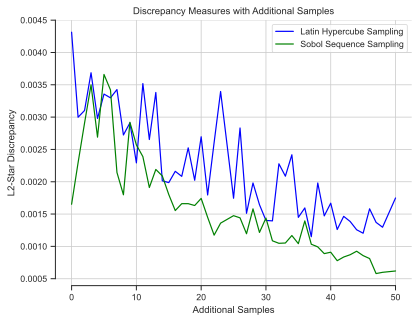

In [59]:
dim = 3
sobol_sampler = qmc.Sobol(d=dim, scramble=True)
lhs_sampler = qmc.LatinHypercube(d=dim)

init_samples = 32
additional_samples = jnp.linspace(0, 50, 49, dtype=int)

X_lhs = lhs_sampler.random(n=init_samples)
X_sobol = sobol_sampler.random(n=init_samples)

lhs_discrepancy = []
sobol_discrepancy = []

for N in additional_samples:
    # Generate initial samples
    lhs_initial = lhs_sampler.random(n=init_samples)
    sobol_initial = sobol_sampler.random(n=init_samples)
    
    # Generate additional samples
    lhs_additional = lhs_sampler.random(n=N)
    sobol_additional = sobol_sampler.random(n=N)
    
    # Combine samples
    lhs_combined = jnp.vstack([lhs_initial, lhs_additional])
    sobol_combined = jnp.vstack([sobol_initial, sobol_additional])
    
    # Calculate discrepancy measures
    lhs_discrepancy.append(qmc.discrepancy(lhs_combined, method='CD'))
    sobol_discrepancy.append(qmc.discrepancy(sobol_combined, method='CD'))

# Plotting
fig, ax = plt.subplots()
ax.plot(additional_samples, lhs_discrepancy, label='Latin Hypercube Sampling', color='blue')
ax.plot(additional_samples, sobol_discrepancy, label='Sobol Sequence Sampling', color='green')
ax.set_xlabel('Additional Samples')
ax.set_ylabel('L2-Star Discrepancy')
ax.set_title('Discrepancy Measures with Additional Samples')
ax.legend()
ax.grid(True)
sns.despine(trim=True)

Here again you can see the superiority of the Sobol sequence in filling the space uniformly when additional samples are taken.